In [1]:
import experiment_utils
from experiment_utils import config

config.experiment_name = "0001_poisson_dirichlet_2d"
config.target = "jmlr_docker"
config.debug_mode = True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import probnum as pn

import linpde_gp

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [3]:
%matplotlib inline

In [4]:
plt.rcParams.update(config.tueplots_bundle())
plt.rcParams['text.usetex'] = True

In [5]:
rng = np.random.default_rng(24)

## Problem Definition

In [6]:
bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
    domain=linpde_gp.domains.Box([[-1.0, 1.0], [-1.0, 1.0]]),
    rhs=linpde_gp.functions.Constant(input_shape=(2,), value=2.0),
    boundary_values=linpde_gp.functions.Constant(input_shape=(2,), value=0.0),
)

In [7]:
plt_grid = bvp.domain.uniform_grid((50, 50))

## Prior

In [8]:
prior_gp = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Zero(input_shape=(2,)),
    cov=2.0 ** 2 * linpde_gp.randprocs.covfuncs.TensorProduct(
        linpde_gp.randprocs.covfuncs.Matern((), nu=2.5, lengthscales=1.0),
        linpde_gp.randprocs.covfuncs.Matern((), nu=2.5, lengthscales=1.0),
    ),
)

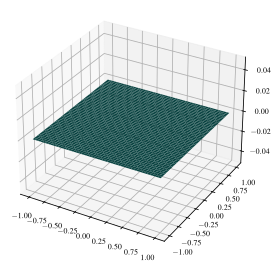

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(plt_grid[..., 0], plt_grid[..., 1], prior_gp.mean(plt_grid))

## Boundary Conditions

In [10]:
N_bc = 20

In [11]:
u_bc = prior_gp

for boundary_condition in bvp.boundary_conditions:
    X_bc = boundary_condition.boundary.uniform_grid(N_bc, inset=1e-6)
    Y_bc = boundary_condition.values(X_bc)

    u_bc = u_bc.condition_on_observations(
        Y_bc,
        X=X_bc,
    )

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((((d*Sqrt(((a-b)*c)**2)+e)*Sqrt(((a-b)*c)**2)+f)*((j*Sqrt(((g-h)*i)**2)+k)*Sqrt(((g-h)*i)**2)+l))*m)*Exp(-(Sqrt(((g-h)*i)**2)+Sqrt(((a-b)*c)**2))) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,1,2), g=Var(6,1,0), h=Var(7,1,1), i=Var(8,1,2), j=Var(9,1,2), k=Var(10,1,2), l=Var(11,1,2), m=Var(12,1,1) ... OK
[pyKeOps] Compiling pykeops cpp 1b88dfd540 module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((((d*Sqrt(((a-b)*c)**2)+e)*Sqrt(((a-b)*c)**2)+f)*((j*Sqrt(((g-h)*i)**2)+k)*Sqrt(((g-h)*i)**2)+l))*m)*Exp(-(Sqrt(((g-h)*i)**2)+Sqrt(((a-b)*c)**2))) with a=Var(0,1,1), b=Var(1,1,0), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,1,2), g=Var(6,1,1), h=Var(7,1,0), i=Var(8,1,2), j=Var(9,1,2), k=Var(10,1,2), l=Var(11,1,2), m=Var(12,1,1) ... OK
[pyKeOps] Compiling pykeops cpp ea4f882615 module ... OK


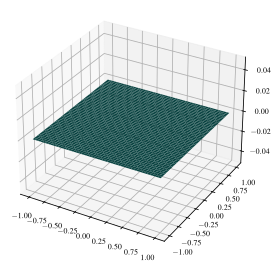

In [12]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(plt_grid[..., 0], plt_grid[..., 1], u_bc.mean(plt_grid))

### Predictive Induced by $\Delta$

In [13]:
Lu_bc = bvp.pde.diffop(u_bc)

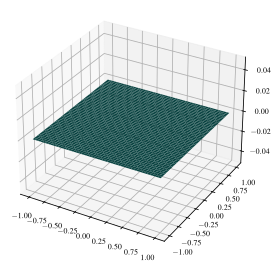

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(plt_grid[..., 0], plt_grid[..., 1], Lu_bc.mean(plt_grid))

### Conditioning on the PDE

In [15]:
N_pde = 20

X_pde = bvp.domain.uniform_grid((N_pde, N_pde))
Y_pde = bvp.pde.rhs(X_pde)

u_bc_pde = u_bc.condition_on_observations(
    Y=Y_pde,
    L=bvp.pde.diffop,
    X=X_pde,
)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (((a*((e*Sqrt(((b-c)*d)**2)+f)*Sqrt(((b-c)*d)**2)+g))*(((k*Sqrt(((h-i)*j)**2)+l)*Sqrt(((h-i)*j)**2)+m)*Exp(-Sqrt(((h-i)*j)**2))))*n)*Exp(-Sqrt(((b-c)*d)**2)) with a=Var(0,1,2), b=Var(1,1,0), c=Var(2,1,1), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,1,2), g=Var(6,1,2), h=Var(7,1,0), i=Var(8,1,1), j=Var(9,1,2), k=Var(10,1,2), l=Var(11,1,2), m=Var(12,1,2), n=Var(13,1,1) ... OK
[pyKeOps] Compiling pykeops cpp bb70d3bb6c module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((((d*Sqrt(((a-b)*c)**2)+e)*Sqrt(((a-b)*c)**2)+f)*(g*((k*Sqrt(((h-i)*j)**2)+l)*Sqrt(((h-i)*j)**2)+m)))*n)*Exp(-(Sqrt(((h-i)*j)**2)+Sqrt(((a-b)*c)**2))) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,1,2), g=Var(6,1,2), h=Var(7,1,0), i=Var(8,1,1), j=Var(9,1,2), k=Var(10,1,2), l=Var(11,1,2), m=Var(12,1,2), n=Var(13,1,1) ... OK
[pyKeOps] Compiling pykeops cpp 7c3e682255 mo

Text(0.5, 0.5, '$x_2$')

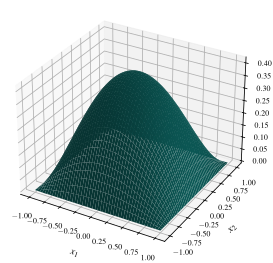

In [16]:
# %matplotlib widget

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(plt_grid[..., 0], plt_grid[..., 1], u_bc_pde.mean(plt_grid))
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

In [17]:
# %matplotlib inline

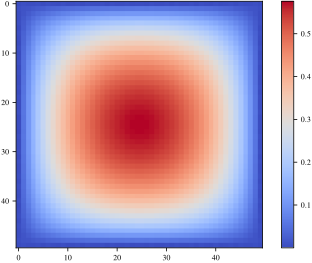

In [18]:
plt.figure()

X_std = np.reshape(plt_grid, (-1, 2))
u_post_std = 1.95 * u_bc_pde.std(X_std).reshape(plt_grid.shape[:-1])

im = plt.imshow(u_post_std, cmap="coolwarm")
plt.colorbar()

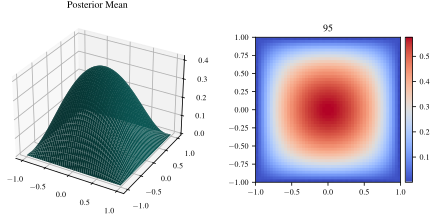

In [19]:
from mpl_toolkits import axes_grid1

fig = plt.figure()
spec = fig.add_gridspec(ncols=2, width_ratios=[0.55, 0.45])

fig.set_constrained_layout_pads(w_pad=10 / 72, h_pad=4 / 72)

# Mean
ax_mean = fig.add_subplot(spec[0], projection="3d")
u_post_mean_surf = ax_mean.plot_surface(
    plt_grid[..., 0],
    plt_grid[..., 1],
    u_bc_pde.mean(plt_grid),
)

ax_mean.set_title("Posterior Mean")

# 95% Credible Interval
ax_std = fig.add_subplot(spec[1])
u_post_std_img = ax_std.imshow(
    u_post_std,
    cmap="coolwarm",
    extent=[-1., 1., -1., 1.],
)

ax_std.set_title("95% Confidence Interval")

# Colorbar
divider = axes_grid1.make_axes_locatable(ax_std)
cax = divider.append_axes(
    "right",
    size="5%",
    pad=plt.rcParams['figure.subplot.wspace'] / 3.0
)
fig.colorbar(u_post_std_img, cax=cax)

experiment_utils.savefig("poisson_2d_posterior")

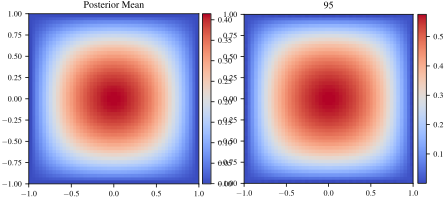

In [20]:
fig, ax = plt.subplots(ncols=2)

# Mean
u_post_mean_img = ax[0].imshow(
    u_bc_pde.mean(plt_grid),
    cmap="coolwarm",
    extent=[-1., 1., -1., 1.],
)

divider = axes_grid1.make_axes_locatable(ax[0])
cax = divider.append_axes(
    "right",
    size="5%",
    pad=plt.rcParams['figure.subplot.wspace'] / 4.0
)
fig.colorbar(u_post_mean_img, cax=cax)

ax[0].set_title("Posterior Mean")

# 95% Credible Interval
u_post_std_img = ax[1].imshow(
    u_post_std,
    cmap="coolwarm",
    extent=[-1., 1., -1., 1.],
)

divider = axes_grid1.make_axes_locatable(ax[1])
cax = divider.append_axes(
    "right",
    size="5%",
    pad=plt.rcParams['figure.subplot.wspace'] / 3.0
)
fig.colorbar(u_post_std_img, cax=cax)

ax[1].set_title("95% Confidence Interval")

experiment_utils.savefig("poisson_2d_posterior_heatmap")